## Packages + support code needed:

These include many of the familiar packages, and an excerpt from the pygeotools package, imported as individual functions thanks to David and Shashank. I am running this notebook on Windows, and because of some apparant problems with system paths to gdal in rasterio on Windows I also ran `from osgeo import gdal` as a work-around thanks to much advice and troubleshooting with Amanda.  

In [1]:
# Import packages
from osgeo import gdal 
import numpy as np
import rasterio as rio
from rasterio import plot, mask
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
import rioxarray as rioxarray
import geopandas as gpd
import astropy as ap

In [2]:
#Compiled from pygeotools (dshean) and himat2cryo repositories
#given to me by Shashank

def checkma(a, fix=False):
    #isinstance(a, np.ma.MaskedArray)
    if np.ma.is_masked(a):
        out=a
    else:
        out=np.ma.array(a)
    #added to original code:
    return out

def maskfill(a, iterations=1, erode=False):
    import scipy.ndimage as ndimage 
    a = checkma(a)
    if erode:
        a = mask_islands(a, iterations)
    bmask = (~np.ma.getmaskarray(a))
    bmask_filled = ndimage.morphology.binary_fill_holes(bmask)
    #This will create valid values with a.filled in the original ma
    #a_erode.mask[:] = ~bmask_filled
    #return a_erode
    return ~bmask_filled

def gauss_fltr_astropy_fft(dem, size=None, sigma=None, origmask=False, fill_interior=False):
    
    """
    ***From pygeotools, commit to mainstream repo after full testing***
    # I use this over the direct Gaussian astropy filter  as it is way faster for large kernels
    Astropy gaussian filter properly handles convolution with NaN
    http://stackoverflow.com/questions/23832852/by-which-measures-should-i-set-the-size-of-my-gaussian-filter-in-matlab
    width1 = 3; sigma1 = (width1-1) / 6;
    Specify width for smallest feature of interest and determine sigma appropriately
    sigma is width of 1 std in pixels (not multiplier)
    scipy and astropy both use cutoff of 4*sigma on either side of kernel - 99.994%
    3*sigma on either side of kernel - 99.7%
    If sigma is specified, filter width will be a multiple of 8 times sigma 
    Alternatively, specify filter size, then compute sigma: sigma = (size - 1) / 8.
    If size is < the required width for 6-8 sigma, need to use different mode to create kernel
    mode 'oversample' and 'center' are essentially identical for sigma 1, but very different for sigma 0.3
    The sigma/size calculations below should work for non-integer sigma
    """

    #import astropy.nddata
    import astropy.convolution
    dem = checkma(dem)
    #Generate 2D gaussian kernel for input sigma and size
    #Default size is 8*sigma in x and y directions
    #kernel = astropy.nddata.make_kernel([size, size], sigma, 'gaussian')
    #Size must be odd
    if size is not None:
        size = int(np.floor(size/2)*2 + 1)
        size = max(size, 3)
    #Truncate the filter at this many standard deviations. Default is 4.0
    truncate = 3.0
    if size is not None and sigma is None:
        sigma = (size - 1) / (2*truncate)
    elif size is None and sigma is not None:
        #Round up to nearest odd int
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    elif size is None and sigma is None:
        #Use default parameters
        sigma = 1
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    size = max(size, 3)
    kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size=size, y_size=size, mode='oversample')

    print("Applying gaussian smoothing filter with size %i and sigma %0.3f (sum %0.3f)" % \
            (size, sigma, kernel.array.sum()))

    #This will fill holes
    #np.nan is float
    #dem_filt_gauss = astropy.nddata.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #dem_filt_gauss = astropy.convolution.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #Added normalization to ensure filtered values are not brightened/darkened if kernelsum != 1
    dem_filt_gauss = astropy.convolution.convolve_fft(dem.astype(float).filled(np.nan), kernel, boundary='fill', 
                                                      fill_value=np.nan, normalize_kernel=True,
                                                     allow_huge=True)
    #This will preserve original ndv pixels, applying original mask after filtering
    if origmask:
        print("Applying original mask")
        #Allow filling of interior holes, but use original outer edge
        if fill_interior:
            mask = maskfill(dem)
        else:
            mask = dem.mask
        dem_filt_gauss = np.ma.array(dem_filt_gauss, mask=mask, fill_value=dem.fill_value)
    out = np.ma.fix_invalid(dem_filt_gauss, copy=False, fill_value=dem.fill_value)
    out.set_fill_value(dem.fill_value.astype(dem.dtype))
    return out.astype(dem.dtype), size

In [3]:
#Define diverging color-ramp used in entire notebook
#color = 'PiYG'#Pink and Green
color = 'RdBu'#Red and Blue
#color = 'RdYlGn' #Red and Green with yellow in middle

## Methods with code

### Loading data and adding overviews


In [4]:

wet1_1 = '../KID13_data/20201109_KID13_LiDAR.tif'
wet1_2 = '../KID13_data/20220208_wittkopf2_KID13_dsm.tif'
wet1_3 = '../KID13_data/alvis_20210406_KID13_20230526_dsm.tif'
wet1_4 = '../KID13_data/20210513_wittkopf5_KID13_dsm.tif'

Adding overviews using `gdaladdo` only needs to be done to a .tif once and some have them in their metadata already, so check whether overviews already exist and then uncomment code as needed. I've commented these out because they take a second to run, take up space in the notebook and I don't need them. 

In [11]:
# !gdalinfo $wet1_1
# !gdalinfo $wet1_2

#!gdaladdo $wet1_1
'''all wet1 are fine to use full resolution '''

'all wet1 are fine to use full resolution '

Next step is to use `rioxarray.open_rasterio().squeeze` with `overview_level = 2` and `mask_and_scale = True` specified. Overview 2 was chosen because it is the lowest resolution that doesn't have visible blocks of pixels for these data. During testing of this code this was convenient to run the functions faster. I also load a DataArray of the full resolution version here, which I will use for the remainder of this example 

In [6]:
wet1_1da_full = rioxarray.open_rasterio(wet1_1, mask_and_scale = True).squeeze()

wet1_2da_full = rioxarray.open_rasterio(wet1_2, mask_and_scale= True).squeeze()
wet1_3da_full = rioxarray.open_rasterio(wet1_3, mask_and_scale= True).squeeze()
wet1_4da_full = rioxarray.open_rasterio(wet1_4, mask_and_scale = True).squeeze()

I'm also loading here a polygon shapefile drawn in QGIS according to the shape of the road. 

In [7]:
mask_path = '../KID13_data/KID13_UTM.shp'
mask_gdf = gpd.read_file(mask_path)

### Clipping, Reprojecting and Matching
QUESTION: this is using cubic resampling right now, but in our meeting David mentioned bilinear, I'm not sure if that was an offhand comment of an example of a type of resampling or if that is the one I should use? Cubic seems to be the more thorough method and there's no problems with processing times so probably stick with that? API reference: https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling 


In [13]:
#clipping using rioxarray
#be sure to specify desired resolution when calling the dataArray
wet1_1clipped = wet1_1da_full.rio.clip(mask_gdf.geometry)
wet1_2clipped = wet1_2da_full.rio.clip(mask_gdf.geometry)
wet1_3clipped = wet1_3da_full.rio.clip(mask_gdf.geometry)
wet1_4clipped = wet1_4da_full.rio.clip(mask_gdf.geometry)

#reprojecting and matching
wet1_1clipped_proj = wet1_2clipped.rio.reproject_match(wet1_2clipped, resampling = 3)
wet1_3clipped_proj = wet1_3clipped.rio.reproject_match(wet1_2clipped, resampling = 3)
wet1_4clipped_proj = wet1_4clipped.rio.reproject_match(wet1_2clipped, resampling = 3)

da_extent_wet1 = wet1_1clipped_proj.rio.bounds()

### Differencing

After two datasets have been loaded and reprojected to match abitrary coordinate systems, they can be differenced and plotted.

In [15]:
wet1_2minuswet1_1 = wet1_2clipped - wet1_1clipped_proj  
wet1_3minuswet1_1 = wet1_3clipped_proj - wet1_1clipped_proj   
wet1_4minuswet1_1 = wet1_4clipped_proj - wet1_1clipped_proj   


### High-pass Gaussian filtering

This is where the high-pass filter shines, allowing me to take another difference that eliminates the noise seen in the other difference. 

In [16]:
#This controls width of gaussian kernel standard deviation in pixels
#50 chosen for full resolution
#10 for overview 2
sigma = 100
ds_wet1_2minuswet1_1, size = gauss_fltr_astropy_fft(wet1_2minuswet1_1, sigma = sigma)
ds_wet1_3minuswet1_1, size = gauss_fltr_astropy_fft(wet1_3minuswet1_1, sigma = sigma)
ds_wet1_4minuswet1_1, size = gauss_fltr_astropy_fft(wet1_4minuswet1_1, sigma = sigma)

dhp_wet1_2minuswet1_1 = wet1_2minuswet1_1 - ds_wet1_2minuswet1_1
dhp_wet1_3minuswet1_1 = wet1_3minuswet1_1 - ds_wet1_3minuswet1_1
dhp_wet1_4minuswet1_1 = wet1_4minuswet1_1 - ds_wet1_4minuswet1_1

Applying gaussian smoothing filter with size 601 and sigma 100.000 (sum 0.995)
Applying gaussian smoothing filter with size 601 and sigma 100.000 (sum 0.995)
Applying gaussian smoothing filter with size 601 and sigma 100.000 (sum 0.995)


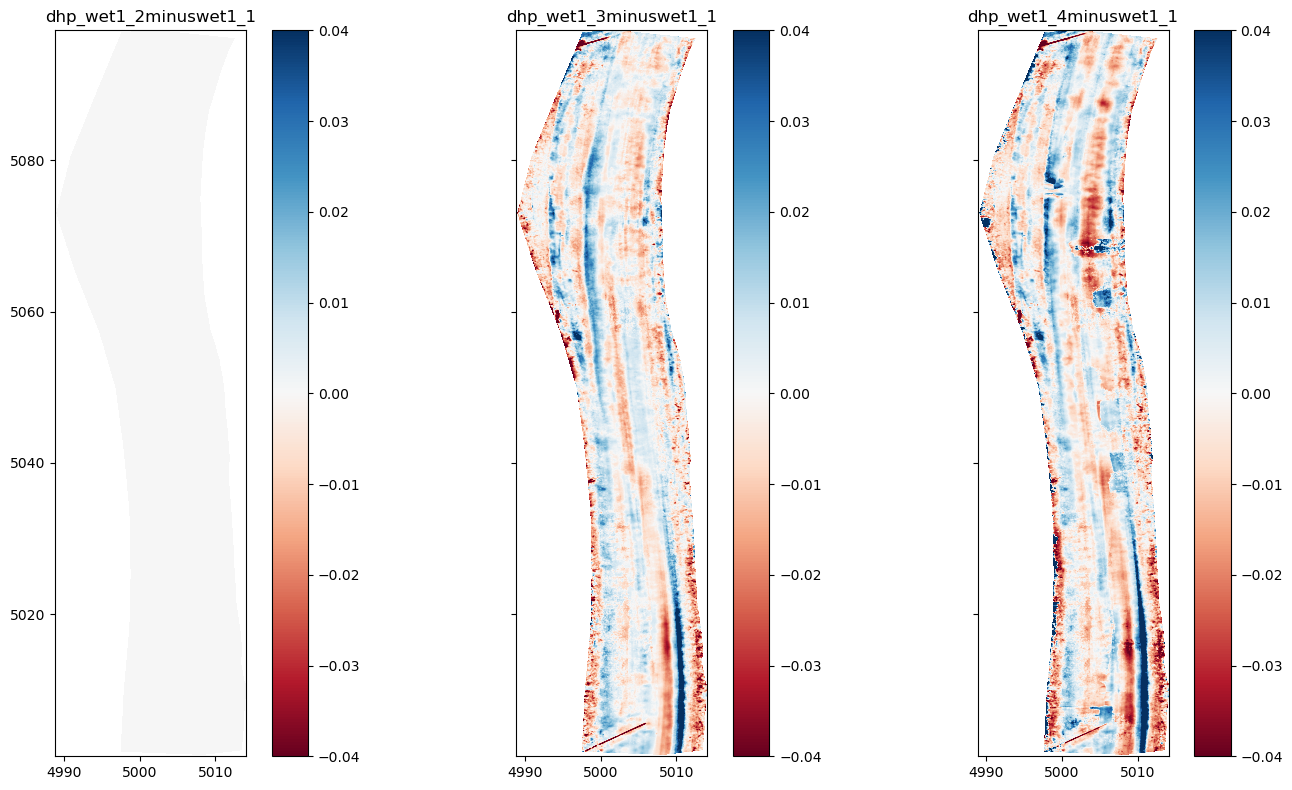

In [17]:
vmin= -0.04
vmax= 0.04

f, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,8))

m = axa[0].imshow(dhp_wet1_2minuswet1_1, cmap = color , vmin = vmin, vmax = vmax, extent = da_extent_wet1)
f.colorbar(m, ax=axa[0])
axa[0].set_title("dhp_wet1_2minuswet1_1")

m = axa[1].imshow(dhp_wet1_3minuswet1_1, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent_wet1)
f.colorbar(m, ax=axa[1])
axa[1].set_title("dhp_wet1_3minuswet1_1")

m = axa[2].imshow(dhp_wet1_4minuswet1_1, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent_wet1)
f.colorbar(m, ax=axa[2])
axa[2].set_title("dhp_wet1_4minuswet1_1")
    

#plt.savefig('KIDWet1DiffMade6_13_23.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

In [12]:

dry1 = '../KID13_data/20210604_wittkopf_KID13_dsm.tif'
dry2 = '../KID13_data/alvis_20210819_KID13_dsm.tif'
dry3 = '../KID13_data/20210913_wittkopf_KID13_dsm.tif'


In [13]:
#!gdalinfo $dry1
#!gdaladdo $dry1
'''all dry season dsms are fine to use full resolution '''

'all dry season dsms are fine to use full resolution '

In [14]:
dry1da_ov1 = rioxarray.open_rasterio(dry1, mask_and_scale = True).squeeze()

dry2da_full = rioxarray.open_rasterio(dry2, mask_and_scale= True).squeeze()
dry3da_full = rioxarray.open_rasterio(dry3, mask_and_scale= True).squeeze()

In [15]:
#clipping using rioxarray
#be sure to specify desired resolution when calling the dataArray
dry1clipped = dry1da_ov1.rio.clip(mask_gdf.geometry)
dry2clipped = dry2da_full.rio.clip(mask_gdf.geometry)
dry3clipped = dry3da_full.rio.clip(mask_gdf.geometry)

#reprojecting and matching
dry2clipped_proj = dry2clipped.rio.reproject_match(dry1clipped, resampling = 3)
dry3clipped_proj = dry3clipped.rio.reproject_match(dry1clipped, resampling = 3)

da_extent_dry = dry2clipped_proj.rio.bounds()

In [16]:
dry2minusdry1 = dry2clipped_proj - dry1clipped  
dry3minusdry1 = dry3clipped_proj - dry1clipped


In [17]:
#This controls width of gaussian kernel standard deviation in pixels
#50 chosen for full resolution
#10 for overview 2
sigma = 100
ds_dry1minusdry2, size = gauss_fltr_astropy_fft(dry2minusdry1, sigma = sigma)
ds_dry1minusdry3, size = gauss_fltr_astropy_fft(dry3minusdry1, sigma = sigma)

dhp_dry1minusdry2 = dry2minusdry1 - ds_dry1minusdry2
dhp_dry1minusdry3 = dry3minusdry1 - ds_dry1minusdry3


Applying gaussian smoothing filter with size 601 and sigma 100.000 (sum 0.995)
Applying gaussian smoothing filter with size 601 and sigma 100.000 (sum 0.995)


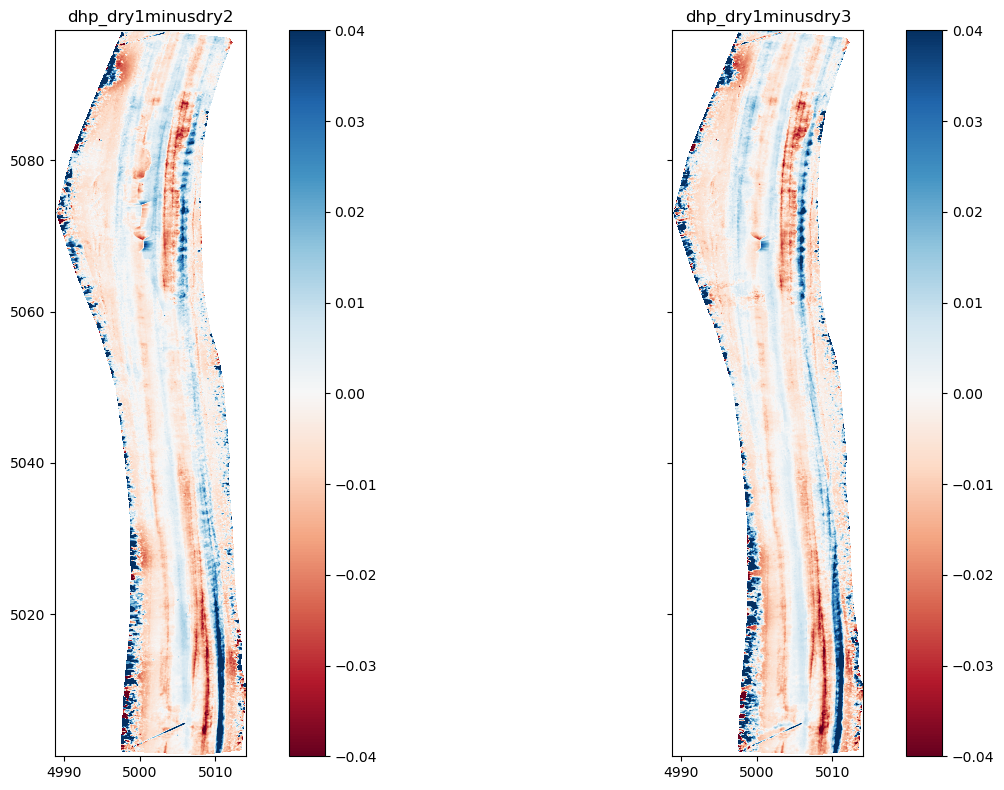

In [18]:
vmin= -0.04
vmax= 0.04

f, axa = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,8))

m = axa[0].imshow(dhp_dry1minusdry2, cmap = color , vmin = vmin, vmax = vmax, extent = da_extent_dry)
f.colorbar(m, ax=axa[0])
axa[0].set_title("dhp_dry1minusdry2")

m = axa[1].imshow(dhp_dry1minusdry3, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent_dry)
f.colorbar(m, ax=axa[1])
axa[1].set_title("dhp_dry1minusdry3")
    

#plt.savefig('KIDDryDiffMade6_13_23.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

In [19]:

wet2_1 = '../KID13_data/20211007_wittkopf_KID13_dsm.tif'
wet2_2 = '../KID13_data/20220208_wittkopf2_KID13_dsm.tif'
wet2_3 = '../KID13_data/20220503_wittkopf2_KID13_dsm.tif'
wet2_4 = '../KID13_data/20220531_wittkopf_KID13_dsm.tif'

In [20]:
#!gdalinfo $wet2_4
#!gdaladdo $wet1_1
'''all wet2 dsms are fine to use full resolution '''

'all wet2 dsms are fine to use full resolution '

In [21]:
wet2_1da_full = rioxarray.open_rasterio(wet2_1, mask_and_scale = True).squeeze()

wet2_2da_full = rioxarray.open_rasterio(wet2_2, mask_and_scale= True).squeeze()
wet2_3da_full = rioxarray.open_rasterio(wet2_3, mask_and_scale= True).squeeze()
wet2_4da_full = rioxarray.open_rasterio(wet2_4, mask_and_scale = True).squeeze()

In [22]:
#clipping using rioxarray

wet2_1clipped = wet2_1da_full.rio.clip(mask_gdf.geometry)
wet2_2clipped = wet2_2da_full.rio.clip(mask_gdf.geometry)
wet2_3clipped = wet2_3da_full.rio.clip(mask_gdf.geometry)
wet2_4clipped = wet2_4da_full.rio.clip(mask_gdf.geometry)

#reprojecting and matching
wet2_2clipped_proj = wet2_2clipped.rio.reproject_match(wet2_1clipped, resampling = 3)
wet2_3clipped_proj = wet2_3clipped.rio.reproject_match(wet2_1clipped, resampling = 3)
wet2_4clipped_proj = wet2_4clipped.rio.reproject_match(wet2_1clipped, resampling = 3)

da_extent_wet2 = wet2_2clipped_proj.rio.bounds()

In [23]:
wet2_1minuswet2_2 = wet2_1clipped - wet2_2clipped_proj 
wet2_1minuswet2_3 = wet2_1clipped - wet2_3clipped_proj 
wet2_1minuswet2_4 = wet2_1clipped - wet2_4clipped_proj 


### High-pass Gaussian filtering

This is where the high-pass filter shines, allowing me to take another difference that eliminates the noise seen in the other difference. 

In [24]:
#This controls width of gaussian kernel standard deviation in pixels
#50 chosen for full resolution
#10 for overview 2
sigma = 100
ds_wet2_1minuswet2_2, size = gauss_fltr_astropy_fft(wet2_1minuswet2_2, sigma = sigma)
ds_wet2_1minuswet2_3, size = gauss_fltr_astropy_fft(wet2_1minuswet2_3, sigma = sigma)
ds_wet2_1minuswet2_4, size = gauss_fltr_astropy_fft(wet2_1minuswet2_4, sigma = sigma)

dhp_wet2_1minuswet2_2 = wet2_1minuswet2_2 - ds_wet2_1minuswet2_2
dhp_wet2_1minuswet2_3 = wet2_1minuswet2_3 - ds_wet2_1minuswet2_3
dhp_wet2_1minuswet2_4 = wet2_1minuswet2_4 - ds_wet2_1minuswet2_4

Applying gaussian smoothing filter with size 601 and sigma 100.000 (sum 0.995)
Applying gaussian smoothing filter with size 601 and sigma 100.000 (sum 0.995)
Applying gaussian smoothing filter with size 601 and sigma 100.000 (sum 0.995)


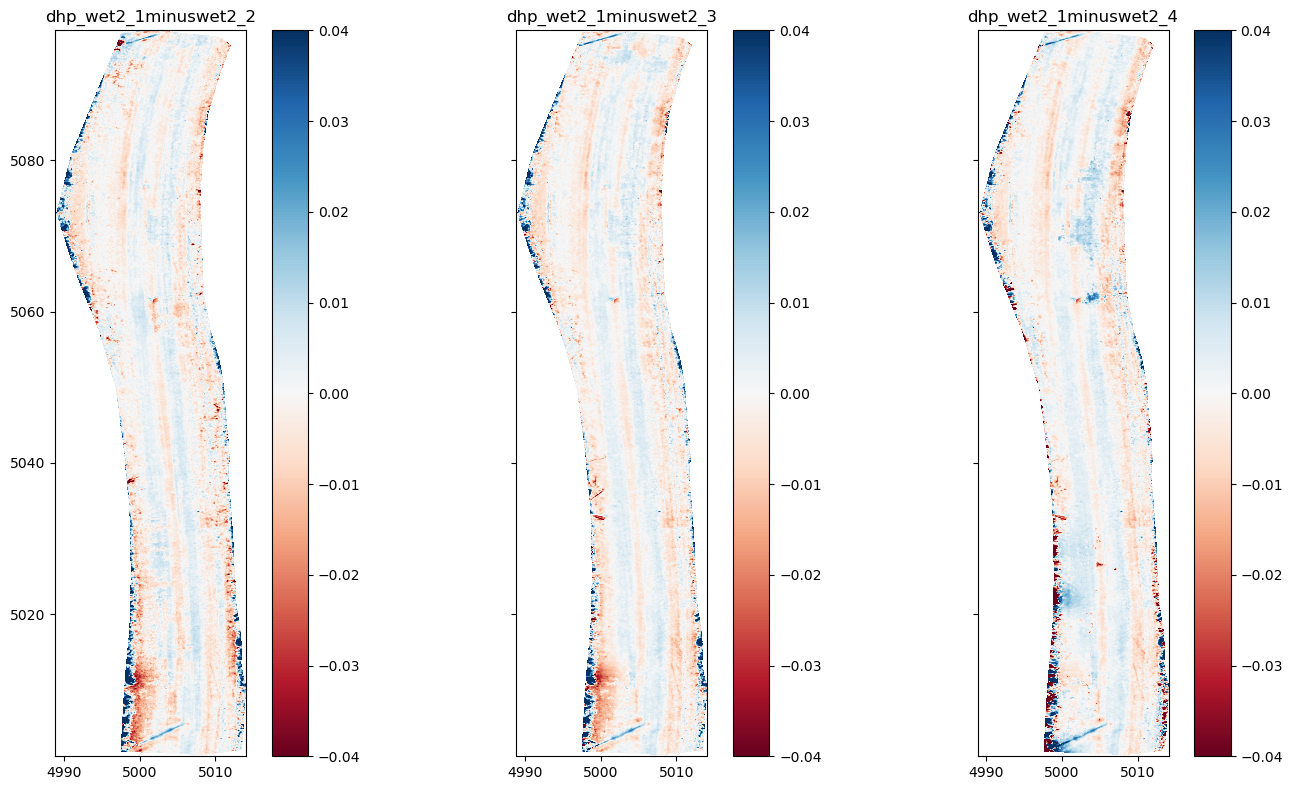

In [25]:
vmin= -0.04
vmax= 0.04

f, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,8))

m = axa[0].imshow(dhp_wet2_1minuswet2_2, cmap = color , vmin = vmin, vmax = vmax, extent = da_extent_wet2)
f.colorbar(m, ax=axa[0])
axa[0].set_title("dhp_wet2_1minuswet2_2")

m = axa[1].imshow(dhp_wet2_1minuswet2_3, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent_wet2)
f.colorbar(m, ax=axa[1])
axa[1].set_title("dhp_wet2_1minuswet2_3")

m = axa[2].imshow(dhp_wet2_1minuswet2_4, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent_wet2)
f.colorbar(m, ax=axa[2])
axa[2].set_title("dhp_wet2_1minuswet2_4")
    

#plt.savefig('KIDWet2DiffMade6_13_23.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

### Longitudinal plot along road
Below is a plot of longitudinal profiles taken across the x-axis of the road, with a step of 0.5 meters. Only those longitudinal profiles that have valid data during most of the length of the road are included here. From this plot we can see that across the road there is a wave occuring that we need to flatten to see more signal and less noise. 

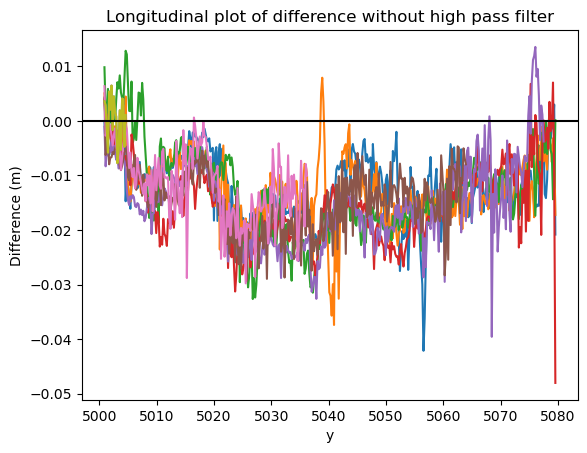

In [44]:
x = np.arange(4994, 4998.5, 0.5)

f, axa = plt.subplots()
ims = []
for i in x:
    ims.append(diff.sel(x=i, method='nearest').plot(ax=axa))
axa.axhline(0, color='k')
axa.set_ylabel('Difference (m)')
axa.set_title('Longitudinal plot of difference without high pass filter')
#attempt to animate but this is all it will show me
# anim = animation.ArtistAnimation(f, ims, interval=2000, repeat_delay=1000)
plt.show()

Now we can look at the same longitudinal plot on the difference after the high pass filter and see that the long wave-form has been flattened so that the differences are more uniformly distributed about 0. So much better!

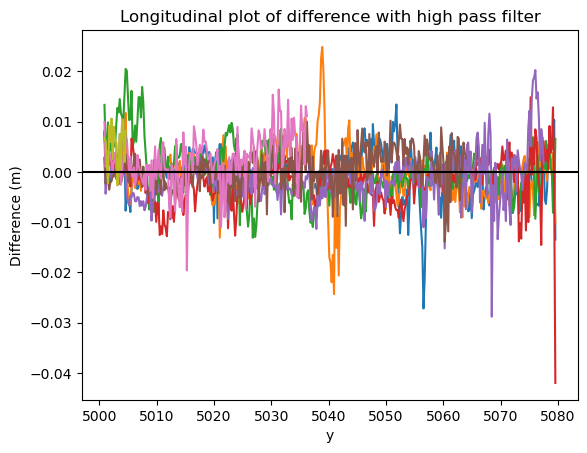

In [48]:
x = np.arange(4994, 4998.5, 0.5)

f, axa = plt.subplots()
ims = []
for i in x:
    ims.append(diff_hp.sel(x=i, method='nearest').plot(ax=axa))
axa.axhline(0, color='k')
axa.set_ylabel('Difference (m)')
axa.set_title('Longitudinal plot of difference with high pass filter')
#attempt to animate but this is all it will show me
# anim = animation.ArtistAnimation(f, ims, interval=2000, repeat_delay=1000)
plt.show()

We can also zoom in on those same areas and see a more meaningful result in micro-topographic feature resolution, with evenly formed ruts that aren't impacted by the road-long waveform

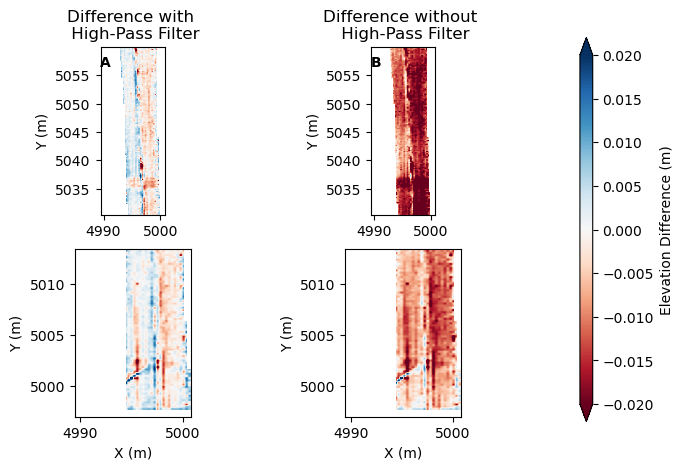

In [61]:
fig, axa = plt.subplots(nrows=2, ncols=2)

im1 = axa[0,0].imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[0,0].set_xlim(175,800)
axa[0,0].set_ylim(a_top, a_bottom)
axa[0,0].set_ylabel('Y (m)')
axa[0,0].set_title('Difference with \n High-Pass Filter')

im2 = axa[1,0].imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[1,0].set_xlim(320,850)
axa[1,0].set_ylim(b_bottom,b_top)
axa[1,0].set_xlabel('X (m)')
axa[1,0].set_ylabel('Y (m)')

im3 = axa[0,1].imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[0,1].set_xlim(175,800)
axa[0,1].set_ylim(a_top, a_bottom)
axa[0,1].set_ylabel('Y (m)')
axa[0,1].set_title('Difference without \n High-Pass Filter')

im4 = axa[1,1].imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[1,1].set_xlim(320,850)
axa[1,1].set_ylim(b_bottom,b_top)
axa[1,1].set_xlabel('X (m)')
axa[1,1].set_ylabel('Y (m)')



cb_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax, label='Elevation Difference (m)', extend='both')

axa[0,0].text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=axa[0,0].transAxes)
axa[0,1].text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=axa[0,1].transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
#plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()